# Plot Training Loss History of Wave Problem

We already saved the training loss history in the saved checkpoints.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import torch
import numpy as np
from matplotlib import pyplot as plt

In [3]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../.."))

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.utils.logger import Logging
from src.utils.plot_loss import plot_loss_history
from src.utils.color import model_color

Set various constant variables: model path, name, etc. We choose the best performing models from each architecture.

In [4]:
TANH_NORM_DIST = "../../model/a2/wave_tanh_normal_a2.pth"
BSPLINE_DIST = "../../model/a1/wave_bspline_a1.pth"
CHEBTSHEV_DIST = "../../model/a1/wave_chebyshev_a1.pth"
GRBF_DIST = "../../model/a2/wave_grbf_a2.pth"
JACOBI_DIST = "../../model/a1/wave_jacobi_a1.pth"
TANH_PARAM_DIST = "../../model/a2/wave_tanh_trainable_a2.pth"
FOURIER_DIST = "../../model/a1/wave_fourier_a1.pth"


MODEL_PATH_LIST = {
    "tanh": TANH_NORM_DIST,
    "param_tanh": TANH_PARAM_DIST,
    "grbf": GRBF_DIST,
    "bspline": BSPLINE_DIST,
    "chebyshev": CHEBTSHEV_DIST,
    "jacobi": JACOBI_DIST,
    "fourier": FOURIER_DIST,
}

SOLVER_TO_MODULE = {
    "KAN_GRBF": "src.nn.grbf",
    "jacobi": "src.nn.jacobi",
    "bspline": "src.nn.bspline",
    "chebyshev": "src.nn.chebyshev",
    "MLP": "src.nn.tanh_parameterized",
    "MLP2": "src.nn.tanh",
    "fourier": "src.nn.fourier",
}

RESULT = "result/wave"

In [5]:
TEST_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, RESULT)
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()
logger.print("file directory:", logger.get_output_dir())

INFO:src.utils.logger:file directory:
INFO:src.utils.logger:/home/ubuntu/afrah/code/pinn_learnable_activation/result/wave/2024-10-12_13-48-55-989391


## Plot Training Loss History

I saved the training loss in a pickle file during training so that I can plot it later if needed.

### Load Saved Model


In [6]:
all_loss_history = {}

for activation, model_path in MODEL_PATH_LIST.items():
    logger.print(f"MODEL_PATH {model_path}")
    # Load the state from the saved model
    state = torch.load(
        model_path,
    )
    config = state.get("config", {})
    solver = config.get("solver")

    # Extract model configuration from state
    model_activation_name = config.get("activation")
    model_architecture = config.get("network")
    loss_history = state.get("loss_history")
    # Dynamically import the correct module and class
    if solver in SOLVER_TO_MODULE:
        module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
        PINNKAN = getattr(module, "PINNKAN")

        # Initialize fluid and solid models
        model = PINNKAN(model_architecture, model_activation_name).to("cpu")

    model.load_state_dict(state["model_state_dict"])
    logger.print(f"Model {activation} loaded from {model_path}")
    logger.print(f"activation:  , {config.get('activation')}")
    logger.print(f"solver:  , {config.get('solver')}")
    logger.print(f"problem:  , {config.get('problem')}")
    logger.print(f"number of iterations:  , {len(next(iter(loss_history.values())))}")
    logger.print(f"batch size:  , {config.get('batch_size')}")
    logger.print(f"network:  , {config.get('network')}")
    logger.print(f"term loss weights :  , {config.get('weights')}")
    all_loss_history[activation] = loss_history
    for lkey, lvalue in loss_history.items():
        logger.print(f"loss: {lkey} , final loss: {lvalue[-1]:.1e}")

INFO:src.utils.logger:MODEL_PATH ../../model/a2/wave_tanh_normal_a2.pth


INFO:src.utils.logger:Model tanh loaded from ../../model/a2/wave_tanh_normal_a2.pth
INFO:src.utils.logger:activation:  , tanh2
INFO:src.utils.logger:solver:  , MLP2
INFO:src.utils.logger:problem:  , None
INFO:src.utils.logger:number of iterations:  , 60001
INFO:src.utils.logger:batch size:  , 128
INFO:src.utils.logger:network:  , [2, 300, 300, 300, 300, 1]
INFO:src.utils.logger:term loss weights :  , [100.0, 100.0, 1.0]
INFO:src.utils.logger:loss: lbcs , final loss: 4.26e-04
INFO:src.utils.logger:loss: linitial , final loss: 7.79e-05
INFO:src.utils.logger:loss: lphy , final loss: 1.17e-01
INFO:src.utils.logger:MODEL_PATH ../../model/a2/wave_tanh_trainable_a2.pth
INFO:src.utils.logger:Model param_tanh loaded from ../../model/a2/wave_tanh_trainable_a2.pth
INFO:src.utils.logger:activation:  , tanh
INFO:src.utils.logger:solver:  , MLP
INFO:src.utils.logger:problem:  , None
INFO:src.utils.logger:number of iterations:  , 60001
INFO:src.utils.logger:batch size:  , 128
INFO:src.utils.logger:ne

Pre-process the loss data for plotting

```py
all_loss_history = {
    model1: {
        loss1: [],
        loss2: [],
        ...
    },
    model2: {
        loss1: [],
        loss2: [],
        ...
    }, 
}

# example

all_loss_history = {
    tanh: {
        lbcs: [],
        phy: [],
        ...
    },
    fourier: {
        lbcs: [],
        phy: [],
        ...
    }, 
}
```


In [7]:
keys = all_loss_history.keys()
values = all_loss_history.values()

# Dictionary to store model and its summed loss
model_summed_loss_dict = {}

# Calculate summed loss
# Iterate over each model, e.g., tanh and sum their losses, e.g, lbcs, phy, ...
for model, loss_dict in zip(keys, values):
    total_loss = np.zeros(
        len(
            next(iter(loss_dict.values()))
        )  # Assume each loss history is of equal length
    )  # Initialize total_loss with zeros

    print(f"{model=}, #iter={len(total_loss)}")

    # Sum all losses across keys for each model
    # Exclude the physics loss for Helmholtz
    for key in loss_dict:
        if key not in ["lphy"]:
            total_loss += np.array(loss_dict[key])

    model_summed_loss_dict[model] = total_loss

# Determine the minimum length across all summed losses
min_length = min([len(x) for x in model_summed_loss_dict.values()])
# Truncate the lists in model_summed_loss_dict to the minimum length
for key in model_summed_loss_dict:
    model_summed_loss_dict[key] = model_summed_loss_dict[key][0:min_length]

print("Truncated model_summed_loss_dict:", model_summed_loss_dict.keys())
print("Truncated model_summed_loss_dict:", len(model_summed_loss_dict.get("tanh")))

model='tanh', #iter=60001
model='param_tanh', #iter=60001
model='grbf', #iter=60001
model='bspline', #iter=60001
model='chebyshev', #iter=60001
model='jacobi', #iter=60001
model='fourier', #iter=60001
Truncated model_summed_loss_dict: dict_keys(['tanh', 'param_tanh', 'grbf', 'bspline', 'chebyshev', 'jacobi', 'fourier'])
Truncated model_summed_loss_dict: 60001


Plot each model's loss


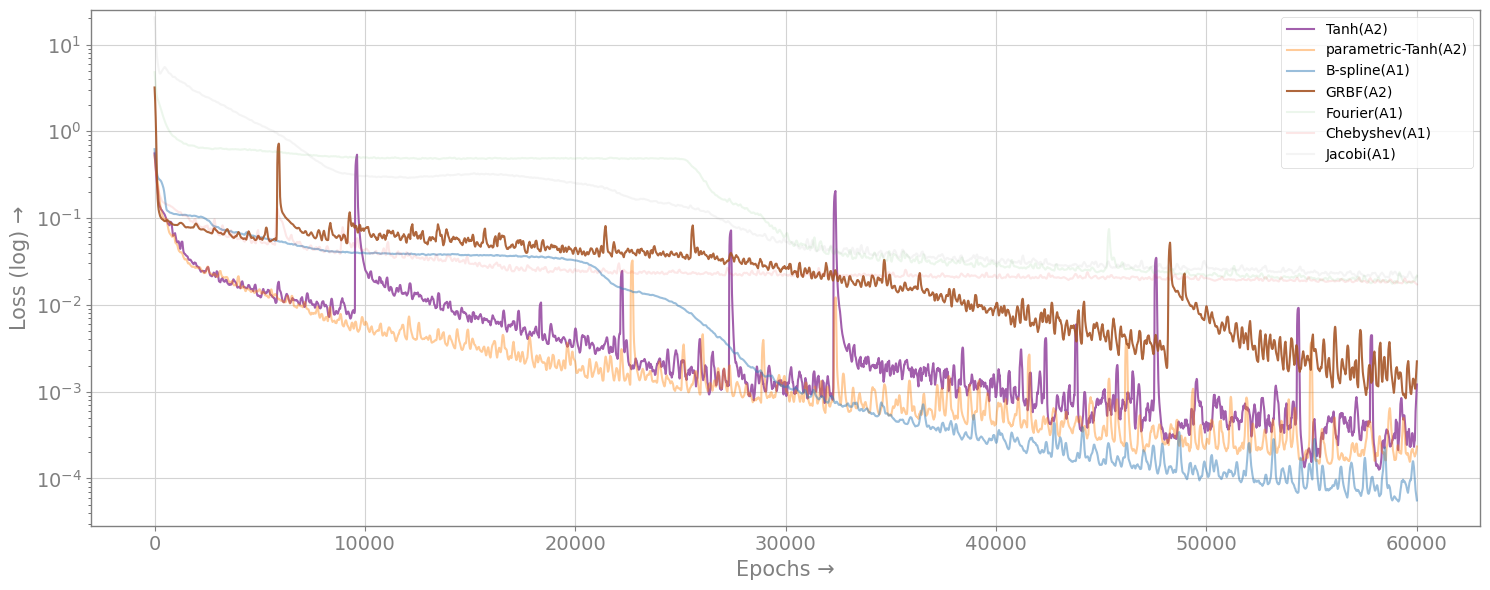

In [8]:
data_list = [
    {
        "data": model_summed_loss_dict["tanh"],
        "color": model_color["tanh"],
        "name": "Tanh(A2)",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
    {
        "data": model_summed_loss_dict["param_tanh"],
        "color": model_color["param_tanh"],
        "name": "parametric-Tanh(A2)",
        "alpha": 0.4,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
    {
        "data": model_summed_loss_dict["bspline"],
        "color": model_color["bspline"],
        "name": "B-spline(A1)",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
    {
        "data": model_summed_loss_dict["grbf"],
        "color": model_color["grbf"],
        "name": "GRBF(A2)",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
    {
        "data": model_summed_loss_dict["fourier"],
        "color": model_color["fourier"],
        "name": "Fourier(A1)",
        "alpha": 0.1,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
    {
        "data": model_summed_loss_dict["chebyshev"],
        "color": model_color["chebyshev"],
        "name": "Chebyshev(A1)",
        "alpha": 0.1,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
    {
        "data": model_summed_loss_dict["jacobi"],
        "color": model_color["jacobi"],
        "name": "Jacobi(A1)",
        "alpha": 0.1,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
        "y_max": 20,
    },
]

plot_loss_history(
    data_list,
    os.path.join(logger.get_output_dir(), "loss_history_wave.png"),
    y_max=25,
)